# TRAIN
# Project 2: Continuous Control
## Udacity Deep Reinforcement Learning Nanodegree

### Preliminaries

Import required dependencies:

In [1]:
from agent_controller import AgentController
from collections import deque
# import cProfile
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from trajectory_collector import TrajectoryCollector
from unityagents import UnityEnvironment

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

## The environment

Choose between a single agent and twenty independent agents for training.

In [3]:
#mode = 'single'
mode = 'multiple'

Define the environment and obtain aspects of it.

In [4]:
environment_path = '../v1/Reacher_Linux_NoVis/Reacher.x86_64' if mode == 'single' else '../v2/Reacher_Linux_NoVis/Reacher.x86_64'

In [5]:
env = UnityEnvironment(file_name=environment_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
agents_n = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

del env_info

## The agent controllers

Define a **first** agent controller that serves as a baseline.

In [7]:
agent_controller_1 = AgentController(
    agents_n=agents_n,

    frames_n=1,    
    state_size=state_size,
    action_size=action_size,
    
    action_distribution="normal",
    hidden_layer_size=128,
        
    sgd_epochs=16,
    minibatch_size=4096,
    sgd_inner_iterations=1,
    
    gamma=0.99,
    gae_lambda=0.95,
                 
    epsilon_start=0.2,
    epsilon_update_factor=1,

    objective_weight_critic_start=0.5,
    objective_weight_critic_update_factor=1,
    
    objective_weight_entropy_start=0,
    objective_weight_entropy_update_factor=1,
        
    learning_rate=3e-4,
    learning_eps=1e-5,
    
    gradient_clip=5
)  

Define a **second** agent controller that is similar to the first, but that uses a Beta distribution instead of a Normal distribution to generate actions. _(Note: The hyperparameters of this agent controller have not otherwise been specifically tuned.)_

In [8]:
agent_controller_2 = AgentController(
    agents_n=agents_n,

    frames_n=1,    
    state_size=state_size,
    action_size=action_size,
    
    action_distribution="beta",
    hidden_layer_size=128,
        
    sgd_epochs=16,
    minibatch_size=4096,
    sgd_inner_iterations=1,
    
    gamma=0.99,
    gae_lambda=0.95,
                 
    epsilon_start=0.2,
    epsilon_update_factor=1,

    objective_weight_critic_start=0.5,
    objective_weight_critic_update_factor=1,
    
    objective_weight_entropy_start=0.001,
    objective_weight_entropy_update_factor=1,
        
    learning_rate=3e-4,
    learning_eps=1e-5,
    
    gradient_clip=5
)  

Define a **third** agent controller that is similar to the first, but that considers two consecutive frames at a time instead of only a single frame. _(Note: The hyperparameters of this agent controller have not otherwise been specifically tuned.)_

In [9]:
agent_controller_3 = AgentController(
    agents_n=agents_n,

    frames_n=2,    
    state_size=state_size,
    action_size=action_size,
    
    action_distribution="normal",
    hidden_layer_size=256,
        
    sgd_epochs=16,
    minibatch_size=4096,
    sgd_inner_iterations=1,
    
    gamma=0.99,
    gae_lambda=0.95,
                 
    epsilon_start=0.2,
    epsilon_update_factor=1,

    objective_weight_critic_start=0.5,
    objective_weight_critic_update_factor=1,
    
    objective_weight_entropy_start=0,
    objective_weight_entropy_update_factor=1,
        
    learning_rate=3e-4,
    learning_eps=1e-5,
    
    gradient_clip=5
)  

## The environment-agent interaction

Define the success criteria.

In [10]:
SOLVED_SCORE = 30
WINDOW_SIZE = 100

Wrap the code that performs training over opisodes:

In [ ]:
VERBOSE = True

In [1]:
def run(agent_controller, checkpoint_name=None):
    """Drives the interaction between the environment and the agent controller.

    Params
    ======
        agent_controller: The agent controller to train.
        checkpoint_name: If a solution is reached, the network weights are stored in a file named after this parameter.
        
    Returns
    =======
        scores: The list of scores achieved at every episode. The score for an episode is defined as the mean score achieved by all agents. An agent's score for an episode is defined as the undiscounted some of rewards for that agent in that episode.
        rolling_mean: A list of rolling means scores over a window of size "WINDOW_SIZE".
        rolling_std: A list of rolling standard deviation scores over a window of size "WINDOW_SIZE".
    """

    verbose_regularity = 10

    max_episodes = 1000

    scores = []
    scores_window = deque(maxlen=WINDOW_SIZE)    
    rolling_scores_mean = []    
    rolling_scores_std = []    
    timer_window = deque(maxlen=WINDOW_SIZE)

    max_steps = 1001 * 1  # Note: It turns out that the Reacher environment always stops after 1001 steps.

    trajectory_collector = TrajectoryCollector(env=env, brain_name=brain_name, agent_controller=agent_controller)

    def get_output_string():
        """A convenience function that returns a string sumarizing the agent controller's performance over the window.
        """
        return f'Episode {i + 1}: score: {latest_score:.4f}; mean_score: {mean_score_in_window:.4f}; std_score: {std_score_in_window:.4f}; avg_time: {np.mean(timer_window):.2f}'

    #####

    for i in range(max_episodes):

        timer_start = time.process_time()

        trajectory_collector.reset_environment()
        trajectories = trajectory_collector.generate(steps_n=max_steps)
        agent_controller.train(trajectories)        

        latest_score = np.mean(torch.sum(trajectories['rewards'], dim=1).cpu().numpy())
        scores.append(latest_score)        
        scores_window.append(latest_score)

        mean_score_in_window = np.mean(scores_window)
        std_score_in_window = np.std(scores_window)

        rolling_scores_mean.append(mean_score_in_window)
        rolling_scores_std.append(std_score_in_window)    

        timer_window.append(time.process_time() - timer_start)

        if VERBOSE and (i + 1) % verbose_regularity == 0:
            print(get_output_string())

        if i >= WINDOW_SIZE - 1 and mean_score_in_window >= SOLVED_SCORE:
            if VERBOSE:
                print(f'Solved! Number of episodes required: {i - WINDOW_SIZE + 2} to {i + 1}.')

            if checkpoint_name:
                agent_controller.save(path=f'checkpoint_{checkpoint_name}.pth')

            break
            
    return {
        'scores': scores, 
        'rolling_mean': rolling_scores_mean, 
        'rolling_std': rolling_scores_std 
    }

## Training the agent controllers

In [12]:
sc_1 = run(agent_controller_1, "agent_controller_1")

Episode 10: score: 1.7360; mean_score: 0.7176; std_score: 0.4710; avg_time: 3.96
Episode 20: score: 4.3175; mean_score: 1.7808; std_score: 1.2323; avg_time: 3.96
Episode 30: score: 11.8100; mean_score: 4.0014; std_score: 3.5664; avg_time: 3.97
Episode 40: score: 23.7690; mean_score: 7.9643; std_score: 7.6832; avg_time: 3.96
Episode 50: score: 31.0860; mean_score: 11.9828; std_score: 10.6309; avg_time: 3.95
Episode 60: score: 34.5720; mean_score: 15.5523; std_score: 12.5756; avg_time: 3.94
Episode 70: score: 36.9420; mean_score: 18.5065; std_score: 13.7099; avg_time: 3.94
Episode 80: score: 38.2600; mean_score: 20.9101; std_score: 14.3150; avg_time: 3.94
Episode 90: score: 38.0100; mean_score: 22.7950; std_score: 14.5116; avg_time: 3.94
Episode 100: score: 37.8665; mean_score: 24.3376; std_score: 14.5242; avg_time: 3.93
Episode 110: score: 38.0465; mean_score: 28.0826; std_score: 12.6588; avg_time: 3.93
Solved! Number of episodes required: 17 to 116.


In [13]:
sc_2 = run(agent_controller_2, "agent_controller_2")

Episode 10: score: 0.8360; mean_score: 0.3400; std_score: 0.2250; avg_time: 4.86
Episode 20: score: 1.9480; mean_score: 0.8274; std_score: 0.5655; avg_time: 4.86
Episode 30: score: 3.2685; mean_score: 1.4627; std_score: 1.0340; avg_time: 4.86
Episode 40: score: 7.2105; mean_score: 2.4035; std_score: 1.9364; avg_time: 4.86
Episode 50: score: 10.5625; mean_score: 3.7288; std_score: 3.2010; avg_time: 4.86
Episode 60: score: 17.7760; mean_score: 5.5261; std_score: 5.0369; avg_time: 4.87
Episode 70: score: 28.2515; mean_score: 8.0940; std_score: 7.9181; avg_time: 4.87
Episode 80: score: 36.6865; mean_score: 11.1477; std_score: 10.9981; avg_time: 4.87
Episode 90: score: 37.0170; mean_score: 13.9927; std_score: 13.1275; avg_time: 4.87
Episode 100: score: 37.4045; mean_score: 16.3323; std_score: 14.2962; avg_time: 4.87
Episode 110: score: 37.0305; mean_score: 20.0813; std_score: 14.5252; avg_time: 4.87
Episode 120: score: 38.0720; mean_score: 23.7528; std_score: 13.9462; avg_time: 4.87
Episode

In [14]:
sc_3 = run(agent_controller_3, "agent_controller_3")

Episode 10: score: 1.2130; mean_score: 0.3543; std_score: 0.3389; avg_time: 3.98
Episode 20: score: 3.2955; mean_score: 1.3098; std_score: 1.1485; avg_time: 3.98
Episode 30: score: 8.6725; mean_score: 2.7238; std_score: 2.3823; avg_time: 3.97
Episode 40: score: 17.6270; mean_score: 5.4258; std_score: 5.3421; avg_time: 3.97
Episode 50: score: 26.0410; mean_score: 9.0383; std_score: 8.7123; avg_time: 3.97
Episode 60: score: 31.2905; mean_score: 12.3474; std_score: 10.8832; avg_time: 3.97
Episode 70: score: 33.1630; mean_score: 15.1006; std_score: 12.1272; avg_time: 3.97
Episode 80: score: 32.7665; mean_score: 17.3073; std_score: 12.7597; avg_time: 3.97
Episode 90: score: 33.3405; mean_score: 19.0757; std_score: 13.0291; avg_time: 3.97
Episode 100: score: 32.8760; mean_score: 20.5101; std_score: 13.0898; avg_time: 3.97
Episode 110: score: 34.1665; mean_score: 23.8856; std_score: 11.7396; avg_time: 3.97
Episode 120: score: 35.4625; mean_score: 27.1734; std_score: 9.6384; avg_time: 3.97
Epi

#### Remarks

All three agent controllers are successfully able to solve the task (each in fact having been trained from the independent interactions of twenty agents, as set out at the top of this notebook). 

For the single runs shown here, the baseline agent controller, Agent Controller 1, has performed better than Agent Controllers 2 and 3. However, for a fair comparison, multiple repetitions of the runs above need to be performed, followed by a statistical test. In addition, as mentioned earlier, the hyperparameters of Agent Controllers 2 and 3 have not otherwise been tuned here. Nevertheless, as described in the report, Agent Controllers 2 and 3 each introduce an aspect that may be useful in general settings, if not specifically for solving this project.

## Visualized

In [15]:
def visualise_single_training(scores, title):
    """Visualizes a single training of an agent controller. Specifically, the raw scores per epsiode are displayed, as well as
    the rolling mean of scores over a window of episodes.
    """
    plt.plot(scores['scores'], color='gray', label='Episode')
    plt.plot(scores['rolling_mean'], color='blue', label='Rolling mean')
        
    plt.title(title)
    plt.ylabel('score')
    plt.xlabel('episode')
    plt.xlim(left=0)
    plt.xlim(right=400)    
    plt.axhline(y=SOLVED_SCORE, color='red', linestyle='-')
    plt.axvline(x=WINDOW_SIZE, color='gray', linestyle='--')
    plt.axvline(x=len(scores) - WINDOW_SIZE, color='red', linestyle='-')
    
    plt.legend(loc='upper left')
    
    plt.show()   

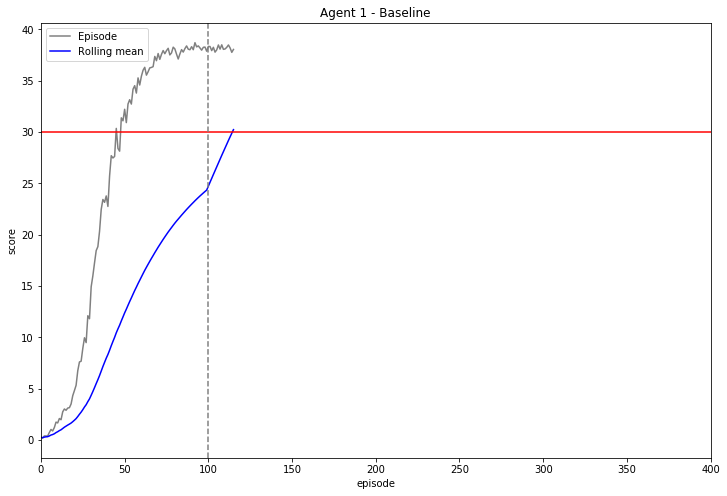

In [16]:
visualise_single_training(sc_1, 'Agent Controller 1 - Baseline')

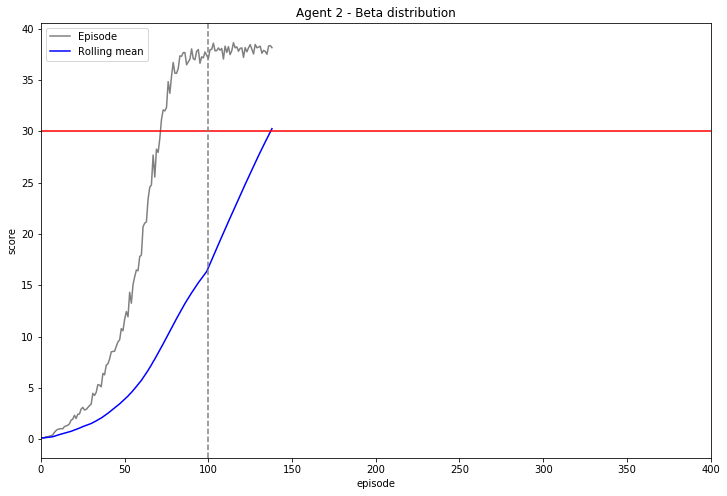

In [17]:
visualise_single_training(sc_2, 'Agent Controller 2 - Beta distribution')

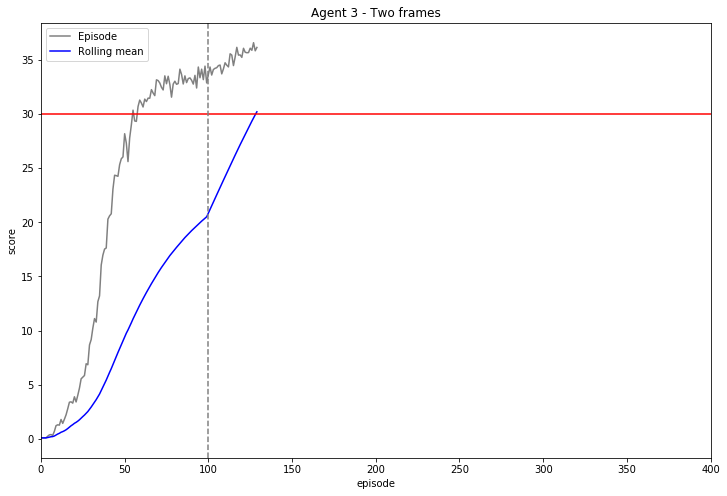

In [18]:
visualise_single_training(sc_3, 'Agent Controller 3 - Two frames')